# Natural Language Processing (NLP) and Neural Networks with NLTK and the Tensorflow Keras API

### Introduction

In this notebook, I will be building a model to predict whether or not a tweet is about a real disaster, using the data given for the assignment. The data has been provided in separate training and test sets, so only the training set will be used in the model training/validation while the test set will be saved for the end to evalute the model.

First the data will be loaded and explored, then the data will be cleaned and preprocessed, and finally the model will be built and trained. I decided to add some features to the data set (e.g. number of words in a tweet) to see if they would improve the model's performance. I also used the prebuild sentiment analysis model from the NLTK library to see if it would improve the model's performance. Finally I used the sklearn library to vectorize the text data with the TF-IDF vectorizer and the nltk tweet tokenizer to tokenize the text data. After all of this, I used the tensorflow.keras library to build and train the model.

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import TweetTokenizer
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve
import random

In [2]:
random.seed(42)

In [3]:
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [4]:
stop_words = set(stopwords.words('english'))

### Custom Functions

list of custom functions:

1. *dtype_convert*: converts the data type of a column in a dataframe
2. *link_count*: if a link exists in a tweet
2. *get_polarity*: returns the polarity of a tweet using the NLTK sentiment analysis model
2. *return_xy*: returns the x and y data from a dataframe
2. *return_vectorized_data*: returns the vectorized text and extra features from a dataframe
2. *plot_history*: plots the training and validation accuracy and loss from a history object
2. *plot_roc*: plots the ROC curve using the best saved model and the test data

In [5]:
def dtype_convert(data):

    int_list = ['int8', 'int16', 'int32', 'int64']
    float_list = ['float16', 'float32', 'float64']

    for col in data.select_dtypes(include=np.number).columns:

        data_type = data[col].dtype
        
        if data_type in int_list:

            n_range = [abs(data[col].max()), abs(data[col].min())]
            n_max = max(n_range)

            if n_max <= 127:
                data[col] = data[col].astype(np.int8)

            elif n_max <= 32767:
                data[col] = data[col].astype(np.int16)

            elif n_max <= 2147483647:
                data[col] = data[col].astype(np.int32)

            else:
                data[col] = data[col].astype(np.int64)

        elif data_type in float_list:
                
                n_range = [abs(data[col].max()), abs(data[col].min())]
                n_max = max(n_range)
    
                if n_max <= 3.4e+38:
                    data[col] = data[col].astype(np.float32)
    
                else:
                    data[col] = data[col].astype(np.float64)
    
    return data
        

In [6]:
def link_count(text):

    links = text.count('http')

    if links > 0:

        return 1
    
    else:

        return 0

In [7]:
def get_polarity(row):

    sia = SentimentIntensityAnalyzer()

    text = row['text']
    polarity = sia.polarity_scores(text)

    neg = polarity['neg']
    neu = polarity['neu']
    pos = polarity['pos']
    compound = polarity['compound']

    return neg, neu, pos, compound

In [8]:
def return_xy(data):

    # Add new features including polarity scores
    # Binary feature for whether a tweet contains a link
    data['links'] = data['text'].apply(link_count).astype(np.int8)
    
    data['tweet_len'] = data['text'].str.len()
    data['word_count'] = data['text'].str.split().str.len()
    data['word_density'] = data['tweet_len'] / (data['word_count'])

    # Get polarity scores
    print('Getting polarity scores...')
    data['neg'], data['neu'], data['pos'], data['compound'] = zip(*data.apply(get_polarity, axis=1))

    # Convert dtypes to save memory
    #data['target'] = data['target'].astype('bool')
    data = dtype_convert(data)
    
    # Columns for X and y
    X = data.drop('target', axis=1)
    y = data['target'].astype('int8')

    return X, y

In [9]:
def return_vectorized_data(train, test, text, features, max_features=None, stop_words=None):

    tk = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

    vectorizer = TfidfVectorizer(tokenizer=tk.tokenize, strip_accents='unicode', max_features=max_features, stop_words=stop_words)

    v_train = vectorizer.fit_transform(train[text])
    v_test = vectorizer.transform(test[text])

    v_train = pd.DataFrame(v_train.toarray(), columns=vectorizer.get_feature_names_out(), index=train.index)
    v_test = pd.DataFrame(v_test.toarray(), columns=vectorizer.get_feature_names_out(), index=test.index)

    v_train = v_train[v_train.columns].astype(np.float32)
    v_test = v_test[v_test.columns].astype(np.float32)

    v_train = v_train.join(train[features], how='left', lsuffix='_v', rsuffix='_f')
    v_test = v_test.join(test[features], how='left', lsuffix='_v', rsuffix='_f')

    return v_train, v_test

In [10]:
def plot_history(history):

    fig, ax = plt.subplots(2, 1, figsize=(11, 11))

    auc_best = np.max(history.history['val_auc'])
    auc_best_epoch = np.argmax(history.history['val_auc'])
    auc_max = history.history['auc'][auc_best_epoch]


    ax[0].plot(history.history['auc'], label='Train')
    ax[0].plot(history.history['val_auc'], label='Validation')
    ax[0].vlines(auc_best_epoch, 0, np.max(history.history['val_auc']), color='purple', linestyles='dashed', label='Best Epoch')

    ax[0].annotate(f'{auc_best - np.max(history.history["auc"]):.4f}',
                    xy=(auc_best_epoch, auc_max),
                    xytext=(auc_best_epoch, auc_best-0.05),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=0.7, headwidth=5))

    ax[0].set_ylabel('AUC')
    #ax[0].set_title('AUC vs. Epoch')
    ax[0].legend(loc='lower left')

    loss_best = np.min(history.history['val_loss'])
    loss_best_epoch = np.argmin(history.history['val_loss'])
    loss_max = history.history['loss'][loss_best_epoch]

    ax[1].plot(history.history['loss'], label='Train')
    ax[1].plot(history.history['val_loss'], label='Validation')
    ax[1].vlines(loss_best_epoch, 0, loss_best, color='purple', linestyles='dashed', label='Best Epoch')

    ax[1].annotate(f'{loss_best - np.min(history.history["loss"]):.4f}',
                    xy=(loss_best_epoch, loss_max),
                    xytext=(loss_best_epoch, loss_best+.01),
                    arrowprops=dict(facecolor='black', shrink=0, width=0.7, headwidth=5))

    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    #ax[1].set_title('Loss vs. Epoch')

    ax[1].legend(loc='lower left')

    plt.show()

In [11]:
def plot_roc(X_train, X_test, y_train, y_test, model):
    
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, model.predict(X_train))
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, model.predict(X_test))

    # Set figure size
    plt.figure(figsize=(10, 10))

    plt.plot(fpr_train, tpr_train, label='Train')
    plt.plot(fpr_test, tpr_test, label='Test')

    plt.legend(['Train', 'Test'], loc='upper left')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC Curve')
    plt.show()

### Import Data

In [12]:
train_data = pd.read_csv('bonus_train_data-2.csv')
test_data = pd.read_csv('bonus_test_data-2.csv')

### Add Features

In [13]:
X_train, y_train = return_xy(train_data)
X_test, y_test = return_xy(test_data)

features = ['tweet_len', 'word_count', 'word_density', 'links', 'neg', 'neu', 'pos', 'compound']

Getting polarity scores...
Getting polarity scores...


### Tokenize and Vectorize Data

In [14]:
# Runs the custom function to vectorize the data
X_train_v, X_test_v = return_vectorized_data(X_train, X_test, 'text', features=features, max_features=None, stop_words=stop_words)

### Train Model

First we convert the dataframes to numpy arrays to work with the keras api. I used the functional api to build the model. It has two hidden layers, a concatenated layer of the original input and previous hidden layers, and one more hidden layer before the output layer. I used the Adam optimizer and the binary crossentropy loss function. I also used the early stopping and checkpoint callbacks to save the best model. I used the fit method to train the model.

In [15]:
# Convert to numpy arrays
X_train_v_n = X_train_v.to_numpy()
X_test_v_n = X_test_v.to_numpy()

y_train_n = y_train.to_numpy()
y_test_n = y_test.to_numpy()

In [16]:
tf.keras.backend.clear_session()

act1 = tf.keras.layers.LeakyReLU(alpha=0.05)

#act1 = tf.keras.activations.

input_ = tf.keras.layers.Input(shape=(X_train_v_n.shape[1],))

x = tf.keras.layers.Dense(32, activation=act1)(input_)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(32, activation=act1)(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Concatenate()([x, input_])
x = tf.keras.layers.Dense(32, activation=act1)(x)
x = tf.keras.layers.Dropout(0.2)(x)

output_ = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(input_, output_)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 17789)]      0           []                               
                                                                                                  
 dense (Dense)                  (None, 32)           569280      ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 32)           0           ['dense[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 32)           1056        ['dropout[0][0]']                
                                                                                              

In [17]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
metric = tf.keras.metrics.AUC()

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=metric)

In [18]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=4, mode='max'),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min'),
             tf.keras.callbacks.ModelCheckpoint(filepath='checkpoint.hd5', monitor='val_auc', save_best_only=True, mode='max')
             ]

model_results = model.fit(X_train_v_n, y_train_n, validation_split=0.02,
                          epochs=100, batch_size=96, callbacks=callbacks,
                          use_multiprocessing=True)

Epoch 1/100
63/63 [==============================] - ETA: 0s - loss: 0.7552 - auc: 0.5064INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


63/63 [==============================] - 4s 50ms/step - loss: 0.7552 - auc: 0.5064 - val_loss: 0.6654 - val_auc: 0.7341
Epoch 2/100
63/63 [==============================] - ETA: 0s - loss: 0.6623 - auc: 0.6269INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


63/63 [==============================] - 3s 45ms/step - loss: 0.6623 - auc: 0.6269 - val_loss: 0.6349 - val_auc: 0.8266
Epoch 3/100
63/63 [==============================] - 2s 32ms/step - loss: 0.6148 - auc: 0.7506 - val_loss: 0.6101 - val_auc: 0.7611
Epoch 4/100
63/63 [==============================] - 1s 14ms/step - loss: 0.5665 - auc: 0.8106 - val_loss: 0.5556 - val_auc: 0.8240
Epoch 5/100
63/63 [==============================] - 1s 15ms/step - loss: 0.5228 - auc: 0.8275 - val_loss: 0.5233 - val_auc: 0.8255
Epoch 6/100
63/63 [==============================] - ETA: 0s - loss: 0.4515 - auc: 0.8760INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


63/63 [==============================] - 2s 39ms/step - loss: 0.4515 - auc: 0.8760 - val_loss: 0.4697 - val_auc: 0.8514
Epoch 7/100
63/63 [==============================] - ETA: 0s - loss: 0.3669 - auc: 0.9210INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


63/63 [==============================] - 2s 35ms/step - loss: 0.3669 - auc: 0.9210 - val_loss: 0.4307 - val_auc: 0.8711
Epoch 8/100
63/63 [==============================] - ETA: 0s - loss: 0.2691 - auc: 0.9578INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


63/63 [==============================] - 2s 35ms/step - loss: 0.2691 - auc: 0.9578 - val_loss: 0.4717 - val_auc: 0.8841
Epoch 9/100
63/63 [==============================] - 2s 36ms/step - loss: 0.2061 - auc: 0.9737 - val_loss: 0.5119 - val_auc: 0.8630
Epoch 10/100
63/63 [==============================] - 1s 19ms/step - loss: 0.1916 - auc: 0.9755 - val_loss: 0.5403 - val_auc: 0.8592


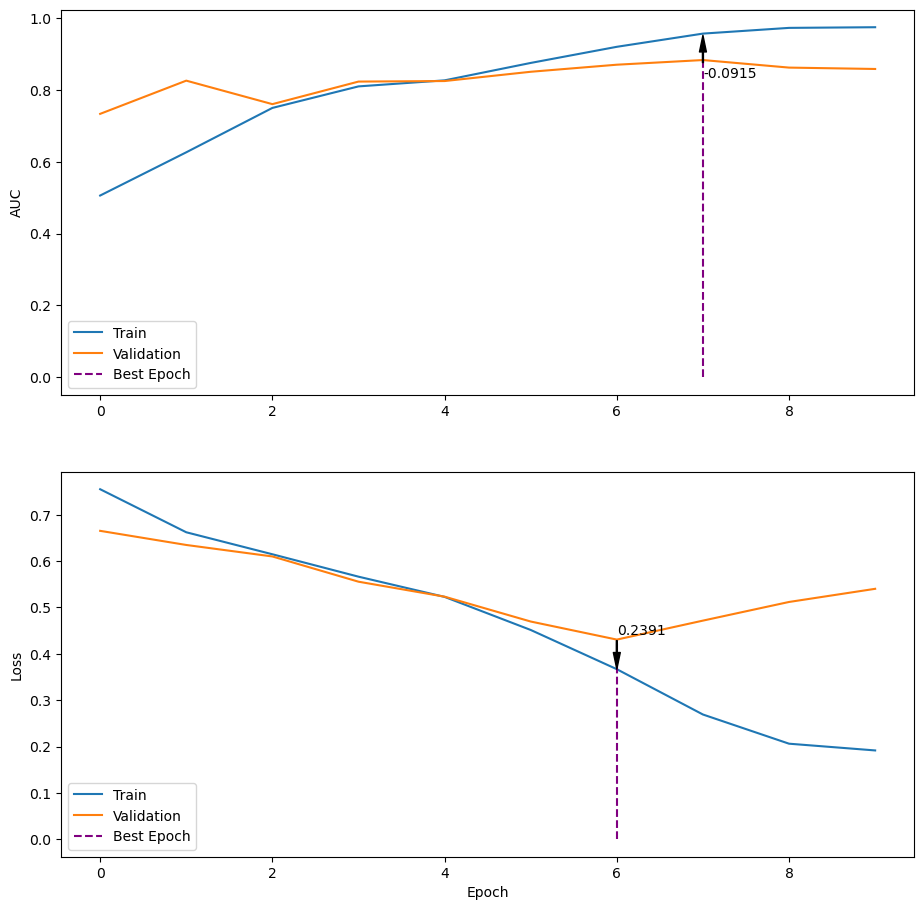

In [19]:
plot_history(model_results)

Above is a plot of the training and validation accuracy and loss. The model seems to be overfitting more as the epochs increase, and we can see the best epoch for loss is around 6, where the best epoch for accuracy is around 7. This indicates that the model may be overfitting and we should stop training the model at around 6 epochs or 7 epochs. However, the model may also be improved by changing the optimizer, learning rate, adding more layers or the amount of training data avaliable.

### Evaluate Model

In [20]:
model.load_weights('checkpoint.hd5')

model.evaluate(X_test_v_n, y_test_n)

48/48 [==============================] - 3s 61ms/step - loss: 0.5063 - auc: 0.8619


[0.5062516331672668, 0.8618751764297485]

48/48 [==============================] - 3s 63ms/step


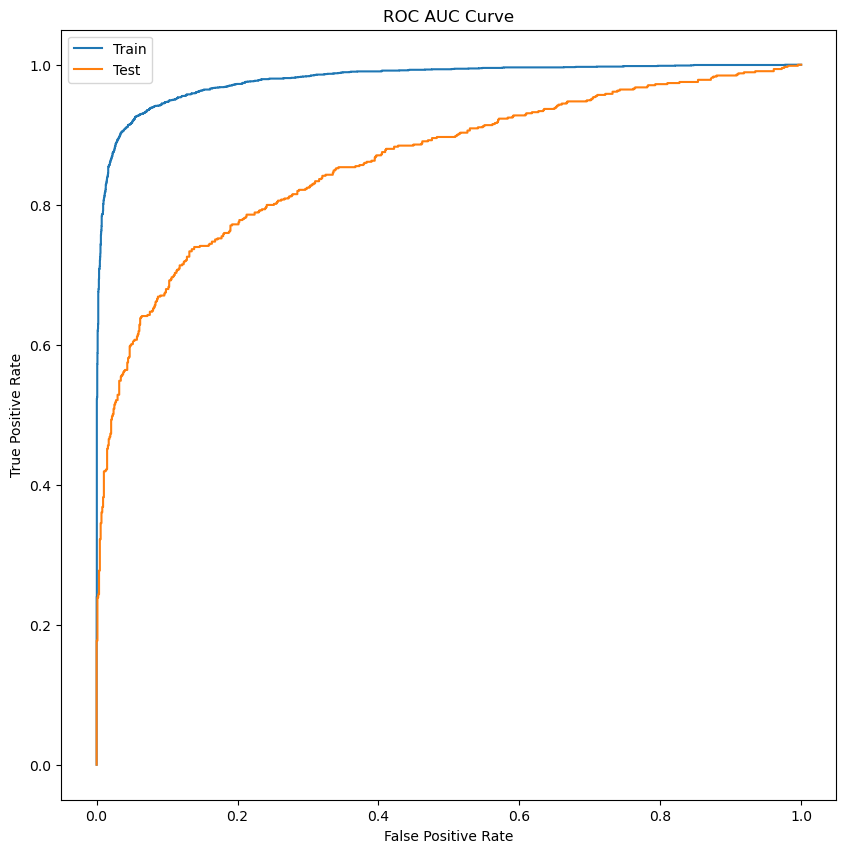

In [21]:
plot_roc(X_train_v_n, X_test_v_n, y_train_n, y_test_n, model)

Above we see the results for our test data set. The model has an AUC of .862, which is not bad. However, from the ROC AUC plot above we can see that the model is still overfitting to the training data and is not generalizing to the test data as well as it could. This could be due to many factors, such as the amount or accuracy of training data, the amount of features, the model architecture, the learning rate, and the amount of epochs. However, the model is still able to predict wheather or not a tweet is about a real disaster with a decent accuracy.